# Investigate the graph

## Import package and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
#df = pd.read_csv('graph_small.csv')
df = pd.read_csv('graph.csv')

## Dead ends: find nodes with no outgoing edges.

In [3]:
# nodes with no incoming edge
is_in_to = df.page_id_from.isin(set(df.page_id_to))
print('We find ',len(df.page_id_from[~is_in_to]), ' nodes with no incoming edges')

We find  633673  nodes with no incoming edges


## Is this graph strongly connected?

In [4]:
# Dead ends: find nodes with no outgoing edge
is_in_from = df.page_id_to.isin(set(df.page_id_from))
dead_ends = df.page_id_to[~is_in_from]
print('We find ',len(dead_ends), ' dead ends, which are the nodes with no outgoing edges')

We find  83826  dead ends, which are the nodes with no outgoing edges


**The graph is not strongly connected because not every node is reachable from every other node.**


## Distribution of in-degrees & Distribution of out-degrees

** The following figure shows the distribution of in-degrees: for every node compute the number of incoming edges **

In [5]:
# in-degrees
in_degrees = df.page_id_to.value_counts()
# out-degrees
out_degrees = df.page_id_from.value_counts()

Text(0.5,0,'out-degrees')

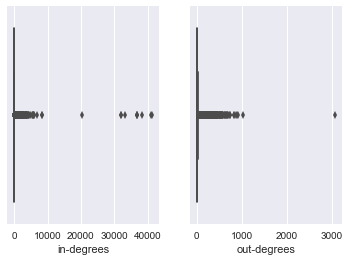

In [6]:
plt.subplot(121) 
sns.boxplot(x= in_degrees)
plt.xlabel('in-degrees')
plt.subplot(122) 
sns.boxplot(x= out_degrees)
plt.xlabel('out-degrees')

From the above box plots, we can see that there are many outliers in the in-dgress and out-degrees. It means there are some pages attracting lots of net traffic(with more than 10k links), while other pages connecting to more than 1k other pages. 

To better show the distribution, we will limit the x-axis.

** The following figure shows the distribution of out-degrees: for every node compute the number of outgoing edges **

Text(0.5,0,'out-degrees, cut at 100')

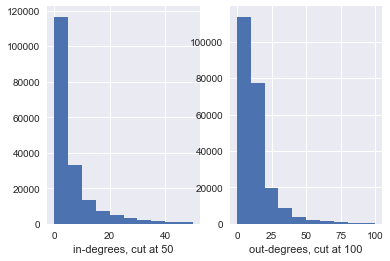

In [7]:
plt.subplot(121) 
in_degrees.hist(range=(0, 50))
plt.xlabel('in-degrees, cut at 50')

plt.subplot(122) 
out_degrees.hist(range=(0, 100))
plt.xlabel('out-degrees, cut at 100')

We can see that most pages have less than 15 coming links and less than 25 outgoing link. 

## The average out-degree and the average in-degree of the graph

In [8]:
# average
ave_out_degrees = out_degrees.mean()
print('The average out-degree of the graph is %6.2f'%(ave_out_degrees))

The average out-degree of the graph is  13.74


In [9]:
ave_in_degrees = in_degrees.mean()
print('The average in-degree of the graph is %6.2f'%(ave_in_degrees))

The average in-degree of the graph is  16.51


## Estimate RAM requirement
### How much RAM would you need to store the transition matrix M and the initial vector v in RAM? 
Assume double precision (64 bits per number).

In [10]:
n_node = len(set(np.concatenate((df['page_id_to'].unique(),df['page_id_from'].unique()), axis=None)))

In [50]:
print('We have %6d nodes in total'%(n_node))

We have 248193 nodes in total


Let's test how much memory a pandas dataframe uses

In [59]:
dummy = pd.DataFrame([[1,0,0,4],[1,0,0,5],[1,0,0,6],[1,0,0,4],[1,0,0,4],[1,0,0,5],[1,0,0,6],[1,0,0,4]])
dummy.memory_usage(index=True, deep=True)

Index    80
0        64
1        64
2        64
3        64
dtype: int64

The pandas dataframe uses 80 bytes for index and 8 bytes per record

In [65]:
# 8 bytes for each number and 80 bytes for index
ram_mat = (n_node**2*8 + 80) * 1024**-3 # RAM for transition matrix M (GB)
ram_vec = (n_node   *8 + 80) * 1024**-3 # RAM for initial vector v (GB)
ram = ram_mat + ram_vec # Total ram
print('We need %6.2f Gb RAM to store the transition matrix M and the initial vector v'%(ram))

We need 458.96 Gb RAM to store the transition matrix M and the initial vector v


### How much RAM would you need to store M in a sparse matrix (in RAM)?

Let's test how much memory a sparse matrix uses

In [76]:
from scipy.sparse import csr_matrix
dummy = csr_matrix(np.arange(4).reshape((2,2)))
dummy.data.nbytes

24

In [77]:
dummy.indptr.nbytes 

12

In [78]:
dummy.indices.nbytes 

12

The sparse matrix uses (rows + 1)*4 bytes for indptr, 8 bytes per non-zero record and 4 bytes for indices per  non-zero record.

In [79]:
# 12 bytes for each number and 80 bytes for index
ram_indptr = (n_node + 1)*4 * 1024**-2 # RAM for indptr (MB)
ram_record = len(df)    *12 * 1024**-2 # RAM for records (MB)
ram_sparse = ram_indptr + ram_record # Total ram
print('We need %6.2f MB RAM if we store M in a sparse matrix'%(ram_sparse))

We need  37.23 MB RAM if we store M in a sparse matrix


### How much RAM would you need using data structures as described on slide 17?

Let's test how much memory a pandas dataframe uses for lists

In [84]:
dummy = pd.DataFrame([[1,2,[1,2]],[1,2,[1,2]],[1,2,[1,2]]])
dummy.memory_usage(index=True, deep=True)

Index     80
0         24
1         24
2        192
dtype: int64

The pandas dataframe use 48 bytes for list index per list

In [85]:
# use data structures as described on slide 17.
n_row = df.page_id_from.nunique() 
ram_numbers = (n_row*2+len(df))*8 * 1024**-2 # RAM for numbers (MB)
ram_index   = (n_row * 48 + 80)   * 1024**-2 # RAM for records (MB)
ram_p17= ram_numbers + ram_index
print('We need %6.2f Mb RAM if we store M as described on slide 17.'%(ram_p17))

We need  38.28 Mb RAM if we store M as described on slide 17.
